In [1]:
import cv2
import numpy as np
import mss
import pyautogui
import time
import win32api
import win32con
import tkinter as tk
from tkinter import messagebox
import json
import threading
from PIL import Image
import matplotlib.pyplot as plt
from tkinter import font
import sys
# np.set_printoptions(threshold=np.inf)


# 配置文件路径
TEMPLATES_FILE = "templates.json"
ROI = {"top": 900, "left": 0, "width": 2560, "height": 550}

# 加载所有英雄模板
def load_all_heroes():
    with open(TEMPLATES_FILE, "r",encoding='utf-8') as file:
        templates = json.load(file)
    all_heroes = {}
    for stage, heroes in templates.items():
        all_heroes[stage]=heroes
    return all_heroes

# 英雄模板路径
TEMPLATES = {}
templates_changed = threading.Event()  # 用于检测模板改变的事件

def capture_screen(region):
    with mss.mss() as sct:
        screenshot = sct.grab(region)
        return cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2RGB)
        # return cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2GRAY)

def match_hero(template_path, screenshot, threshold=0.6):
    template = cv2.imread(template_path, cv2.IMREAD_COLOR)
    if template is None:
        raise ValueError(f"无法加载模板图片：{template_path}")

    # 模板匹配
    result = cv2.matchTemplate(screenshot, template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)

    if max_val > threshold:  # 判断匹配是否超过阈值
        # 获取模板的宽度和高度
        h, w,_ = template.shape

        # 提取匹配区域
        matched_image = screenshot[max_loc[1]:max_loc[1] + h, max_loc[0]:max_loc[0] + w]

        # 返回匹配位置和提取的图像
        return max_loc, matched_image
    else:
        return None, None  # 没有匹配结果时返回 None



def is_greyscale_image(image, threshold=0.8):
    if image.ndim == 3:
        # 计算 R、G、B 三个通道是否相等
        grey_pixels = (image[:, :, 0] == image[:, :, 1])&(image[:, :, 1]==image[:, :, 2])
    else:
        # 如果是单通道灰度图像，直接认为是灰度图像
        grey_pixels = np.ones(image.shape[:2], dtype=bool)

    # 计算三通道相等的像素比例
    grey_pixel_ratio = np.sum(grey_pixels) / grey_pixels.size
    # print(grey_pixel_ratio)

    # 如果相等的像素比例超过阈值，认为是灰度图像
    return grey_pixel_ratio >= threshold

def click(x, y):
    win32api.SetCursorPos((x, y))  # 设置鼠标位置
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTDOWN, 0, 0)  # 鼠标按下
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTUP, 0, 0)  # 鼠标抬起

# 更新全局 TEMPLATES
def update_templates(selected_heroes, all_heroes):
    global TEMPLATES
    all_heroes_copy={}
    for category,heroes in all_heroes.items():
        for hero,j in heroes.items():
            all_heroes_copy[hero]=j
    TEMPLATES = {hero: all_heroes_copy[hero] for hero in selected_heroes}
    templates_changed.set()  # 触发模板改变事件

# 创建选择英雄的 GUI
def create_hero_selection_gui():
    all_heroes = load_all_heroes()  # 加载所有英雄
    selected_heroes = []  # 存储用户选择的英雄

    def on_select(hero, var):
        # 根据复选框的状态更新选中的英雄列表
        if var.get():
            selected_heroes.append(hero)
        else:
            selected_heroes.remove(hero)
        # 更新模板
        update_templates(selected_heroes, all_heroes)

    # 创建主窗口
    root = tk.Tk()
    root.title("选择英雄")
    root.geometry("400x600")
    root.attributes('-topmost', 1)  # 保持窗口在最顶层
    default_font = font.nametofont("TkDefaultFont")
    default_font.configure(family="SimHei", size=12)
# 滚动框架
    frame = tk.Frame(root)
    frame.pack(fill="both", expand=True)
    canvas = tk.Canvas(frame)
    scrollbar = tk.Scrollbar(frame, orient="vertical", command=canvas.yview)
    scrollable_frame = tk.Frame(canvas)

    scrollable_frame.bind(
        "<Configure>",
        lambda e: canvas.configure(scrollregion=canvas.bbox("all"))
    )
    canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
    canvas.configure(yscrollcommand=scrollbar.set)
    canvas.pack(side="left", fill="both", expand=True)
    scrollbar.pack(side="right", fill="y")

    for stage, heroes in all_heroes.items():
        stage_label = tk.Label(scrollable_frame, text=stage, font=("SimHei", 14, "bold"))
        stage_label.pack(anchor="w", padx=10, pady=5)

        # Add checkboxes for heroes under the stage
        for hero in heroes:
            var = tk.BooleanVar()
            checkbox = tk.Checkbutton(
                scrollable_frame,
                text=hero,
                variable=var,
                command=lambda h=hero, v=var: on_select(h, v)
            )
            checkbox.pack(anchor="w", padx=20)

    # def on_save():
    #     messagebox.showinfo("Success", "Selected heroes updated!")
    #     templates_changed.set()
    #
    # save_button = tk.Button(root, text="保存选择", command=on_save)
    # save_button.pack(pady=10)
    def on_close():
        root.quit()
        sys.exit()
    root.protocol("WM_DELETE_WINDOW", on_close)
    root.mainloop()

# 主循环
def main_loop():
    while True:
        screenshot = capture_screen(ROI)
        for hero, template_path in TEMPLATES.items():
            match,matched_image = match_hero(template_path, screenshot)
            if match:
                if is_greyscale_image(matched_image):
                    print("Screenshot is greyscale. Skipping...")
                    break
                x, y = match[0] + ROI["left"]+100, match[1] + ROI["top"]+100
                click(x, y)
                time.sleep(0.2)
                break

# 启动 GUI 和主循环的线程
if __name__ == "__main__":
    gui_thread = threading.Thread(target=create_hero_selection_gui)
    gui_thread.start()

    main_loop()  # 启动主循环，等待模板改变


KeyboardInterrupt: 

In [3]:
print(TEMPLATES)

{'光辉': 'image/1-guanghui.png', '阿卡丽': '2-akali.png'}


图片尺寸: (258, 150)
图片格式: PNG
44.78157916729301


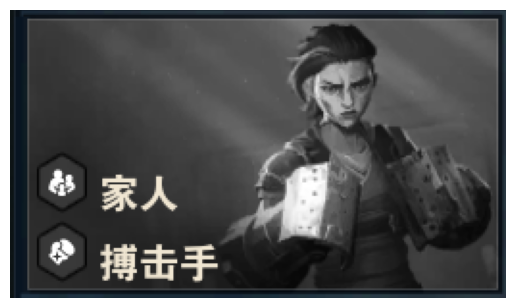

In [8]:


# 读取图片
image_path = "image/greyTest.png"  # 替换为你的图片路径
image = Image.open(image_path)

# 打印图片信息
print(f"图片尺寸: {image.size}")
print(f"图片格式: {image.format}")
print(np.std(image))

# 显示图片
plt.imshow(image)
plt.axis("off")  # 隐藏坐标轴
plt.show()
